# Experiment 3aii: Random Isotropic Perturbations at Thought Anchors (KL vs. ε)

This notebook mirrors Experiment 3a's setup but replaces targeted steering with random isotropic perturbations in the residual stream at selected layers.

Protocol:
- Use the same anchor/counterfactual prompt pairs as in 3a (from the annotated dataset).
- At the token just before the anchor, sample random unit directions in hidden space.
- Scale each perturbation by ε times the RMS of the (unperturbed) residual at that token/layer.
- Compute KL divergence over the anchor chunk next-token distributions vs. the unperturbed run.
- Plot KL vs. ε, averaging over random directions (and examples).


## Combined Curve + Scatter Helpers (random isotropic)

Two-panel figure per layer: left = per-chunk KL vs epsilon colored by a metric; right = amplitude (|a| from quadratic fit) vs that metric.

In [2]:
import os, json, math, random, gc
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

from pathlib import Path
# Find repo root by searching upwards for 'generated_data' (fallback: cwd)
repo_root = Path.cwd().resolve().parents[0] if (Path.cwd()).exists() else Path.cwd().resolve()
from utils import load_model_and_vectors, split_solution_into_chunks

# Parameters (keep consistent with 3a where possible)
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
max_examples = 8  # subset for a quick run; increase as needed
selected_layers = [20, 22, 24, 26]  # e.g., [24, 26, 28]; None = use last layer only
epsilons = np.linspace(0, 10, 21)  # multiples of RMS
n_directions = 32  # random directions per epsilon
seed = 42
random.seed(seed); torch.manual_seed(seed)

# Resolve device in the same way as other experiments
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [3]:
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from utils import normalize_by_group
metric_key_to_label = {
    'kl': 'counterfactual_importance_kl',
    'acc': 'counterfactual_accuracies',
    'diff': 'different_trajectories_fraction',
    'over': 'overdeterminedness',
}

def _get_metric_from_example(ex, idx: int, metric_key: str) -> float:
    arr = ex.get(metric_key_to_label[metric_key], []) or []
    try:
        return float(arr[idx]) if idx < len(arr) else 0.0
    except Exception:
        return 0.0

def _fit_amp_quadratic(xs: np.ndarray, ys: np.ndarray) -> float:
    n = min(xs.size, ys.size)
    if n < 3: return np.nan
    try:
        a = float(np.polyfit(xs[:n], ys[:n], 2)[0]); return abs(a)
    except Exception: return np.nan

def _ensure_figdir(p):
    try: os.makedirs(p, exist_ok=True)
    except Exception: pass

def plot_combined_per_layer(curves_for_layer: list, examples_list: list, x_values: np.ndarray, metric_key: str, L: int, save_tag: str = None):
    vals = []; amps = []
    ex_keys = []
    for c in curves_for_layer:
        ex_i = int(c.get('example_index', 0)); ch_i = int(c.get('chunk_index', 0))
        m = _get_metric_from_example(examples_list[ex_i], ch_i, metric_key)
        vals.append(m)
        ex_keys.append(ex_i)
        amps.append(_fit_amp_quadratic(np.asarray(x_values, dtype=float), np.asarray(c.get('ys', []), dtype=float)))
    M = np.asarray(vals, dtype=float); A = np.asarray(amps, dtype=float); A_norm = np.asarray(normalize_by_group(ex_keys, A), dtype=float)
    vmin, vmax = (0.0, (np.nanmax(M) if np.isfinite(np.nanmax(M)) else 1.0)) if metric_key != 'kl' else (0.0, (np.nanmax(M) if np.isfinite(np.nanmax(M)) else 0.01))
    norm = Normalize(vmin=vmin, vmax=max(vmin+1e-9, vmax)); cmap = plt.cm.viridis

    fig, axes = plt.subplots(1,2, figsize=(12,5))
    ax0, ax1 = axes
    for c, m in zip(curves_for_layer, M):
        ys = np.asarray(c.get('ys', []) or [], dtype=float)
        n = min(len(x_values), len(ys));
        if n == 0: continue
        ax0.plot(x_values[:n], ys[:n], color=cmap(norm(m)), linewidth=1.3, alpha=0.7)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array(M)
    cb = fig.colorbar(sm, ax=ax0, pad=0.02); cb.set_label(metric_key_to_label[metric_key])
    ax0.set_xlabel('epsilon (× RMS)'); ax0.set_ylabel('KL(perturbed || base)'); ax0.set_title(f'Layer {L}: KL vs epsilon (color = {metric_key_to_label[metric_key]})')
    ax0.grid(True, alpha=0.3)

    ax1.scatter(M, A_norm, edgecolor='black', alpha=0.7)
    ax1.set_xlabel(metric_key_to_label[metric_key]); ax1.set_ylabel('normalized |a| (per example)'); ax1.set_title(f'Layer {L}: amplitude vs metric')
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_tag:
        figdir = repo_root / 'generated_data' / 'figures'
        _ensure_figdir(figdir)
        fp = figdir / f'exp3aii_layer{L}_{metric_key}.png'
        try: fig.savefig(fp, dpi=200); print(f'Saved: {fp}')
        except Exception as e: print('Save failed:', e)
    plt.show()



## Combined figures (by metric) per layer

In [4]:
# Build combined two-panel figures per selected layer for 4 metrics
if 'chunk_curves' in globals() and isinstance(chunk_curves, dict) and chunk_curves:
    X = np.asarray(epsilons, dtype=float)
    for L in selected_layers:
        curvesL = chunk_curves.get(L, [])
        if not curvesL:
            continue
        for mk in ['kl','acc','diff','over']:
            plot_combined_per_layer(curvesL, examples, X, mk, L=L, save_tag=f'layer{L}_{mk}')
else:
    print('No per-layer chunk curves available to plot')


No per-layer chunk curves available to plot


In [5]:
# Load model and tokenizer (no features needed)
model, tokenizer, _ = load_model_and_vectors(model_name=model_name, compute_features=False, device=device)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
hidden_size = model.config.hidden_size
num_layers = model.config.num_hidden_layers
if selected_layers is None:
    selected_layers = [num_layers - 1]  # last layer default
selected_layers

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


No mean vectors found for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B. You can save to generated_data/mean_vectors_deepseek-r1-distill-qwen-1.5b.pt.


[20, 22, 24, 26]

In [6]:
# Load annotated dataset produced by Experiment 2
model_tag = model_name.replace('/', '-')
annotated_path = repo_root / 'generated_data' / f'generated_data_annotated_{model_tag}.json'
assert annotated_path.exists(), f'Missing annotated dataset: {annotated_path}'
with open(annotated_path, 'r') as f:
    annotated = json.load(f)
# Filter to examples with an anchor sentence
examples = [ex for ex in annotated if ex.get('thought_anchor_sentence')]
if max_examples is not None:
    examples = examples[:max_examples]
len(examples)

8

In [7]:
from pathlib import Path
print('--- Sanity check ---')
names = []
if 'annotated_path' in globals(): names.append(('annotated_path', str(annotated_path)))
if 'anchors_path' in globals(): names.append(('anchors_path', str(anchors_path)))
if 'vectors_path' in globals(): names.append(('vectors_path', str(vectors_path)))
all_ok = True
for nm, p in names:
    ok = Path(p).exists()
    print(f'{nm}:', 'OK' if ok else 'MISSING', p)
    all_ok = all_ok and ok
try:
    from utils import forward_with_logits, kl_from_logits
    print('utils import: OK')
except Exception as e:
    print('utils import failed:', e); all_ok=False
try:
    import torch
    dev = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
    print('device:', dev)
except Exception as e:
    print('torch not available:', e)
SANITY_OK = all_ok
print('SANITY_OK =', SANITY_OK)


--- Sanity check ---
annotated_path: OK /home/cutterdawes/SteeringThoughtAnchors/generated_data/generated_data_annotated_deepseek-ai-DeepSeek-R1-Distill-Qwen-1.5B.json
utils import: OK
device: cuda
SANITY_OK = True


In [8]:
def find_anchor_token_span(full_text: str, cot_text: str, anchor_sentence: str):
    """Locate token-span [start, end) of the anchor sentence within full_text.
    First try char-to-token mapping; fallback to sub-token sequence search.
    Returns (start_idx, end_idx, think_start_idx_char).
    """
    think_start = full_text.find('<think>')
    if think_start < 0:
        think_start = 0
    # Char mapping approach
    try:
        offsets = tokenizer.encode_plus(full_text, return_offsets_mapping=True)['offset_mapping']
    except Exception:
        offsets = None
    if offsets:
        anchor_char = cot_text.find(anchor_sentence)
        if anchor_char >= 0:
            cot_in_full = full_text.find(cot_text[:max(1, min(20, len(cot_text)))])
            base_char = cot_in_full if cot_in_full >= 0 else think_start
            start_char = base_char + anchor_char
            end_char = start_char + len(anchor_sentence) - 1
            char_to_tok = {}
            for ti, (s,e) in enumerate(offsets):
                for cp in range(s, e):
                    char_to_tok[cp] = ti
            ts = char_to_tok.get(start_char, None)
            te = char_to_tok.get(end_char, None)
            if ts is not None and te is not None and ts < te:
                return ts, te+1, think_start
    # Fallback: sub-token match
    ids_full = tokenizer(full_text, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
    ids_anchor = tokenizer(anchor_sentence, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
    approx_ts = 0
    try:
        prefix = tokenizer(full_text[:think_start], return_tensors='pt', add_special_tokens=False)['input_ids'][0]
        approx_ts = int(prefix.shape[-1])
    except Exception:
        approx_ts = 0
    hay = ids_full[approx_ts:]
    def find_subseq(h, n):
        L, M = len(h), len(n)
        for i in range(max(0, L-M+1)):
            if h[i:i+M] == n:
                return i
        return -1
    pos = find_subseq(hay, ids_anchor)
    if pos >= 0:
        s = approx_ts + pos
        return s, s+len(ids_anchor), think_start
    return None, None, think_start

def build_full_text(ex):
    base = ex.get('raw_response') or ''
    if not base:
        prompt = ex.get('model_input_prompt') or ''
        cot = ex.get('cot') or ''
        base = prompt + cot
    return base

def kl_between_logits(logits_p, logits_q):
    logp = F.log_softmax(logits_p, dim=-1)
    logq = F.log_softmax(logits_q, dim=-1)
    p = logp.exp()
    kl = (p * (logp - logq)).sum(dim=-1)
    return float(kl.mean().item())

def unit_random_direction(dim, device, dtype):
    v = torch.randn(dim, device=device, dtype=torch.float32)
    v = v / (v.norm() + 1e-12)
    return v.to(device=device, dtype=dtype)


In [9]:
from utils import forward_with_logits as _fw, kl_from_logits as _kl

@torch.no_grad()
def _forward_with_logits(input_ids, attention_mask):
    return _fw(model, input_ids=input_ids, attention_mask=attention_mask)

def kl_from_logits(avg_logits_p, avg_logits_q):
    return _kl(avg_logits_p, avg_logits_q)


NameError: name 'summary' is not defined

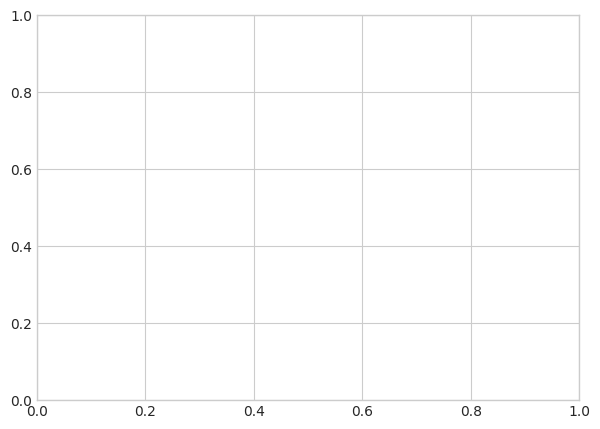

In [ ]:
# Plot KL vs. epsilon per selected layer
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7,5))
for L in selected_layers:
    xs = [float(e) for e in epsilons]
    ys = [summary[L].get(float(e), 0.0) for e in epsilons]
    ax.plot(xs, ys, marker='o', label=f'layer {L}')
ax.set_xlabel('epsilon (× RMS at token_before)')
ax.set_ylabel('KL(perturbed || base) over anchor chunk')
ax.set_title('Random isotropic residual perturbations at anchor (KL vs. ε)')
ax.legend()
plt.tight_layout()
plt.show()

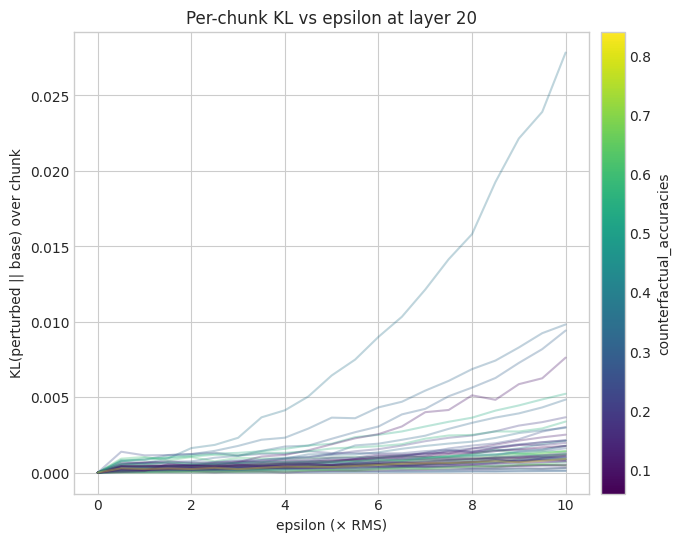

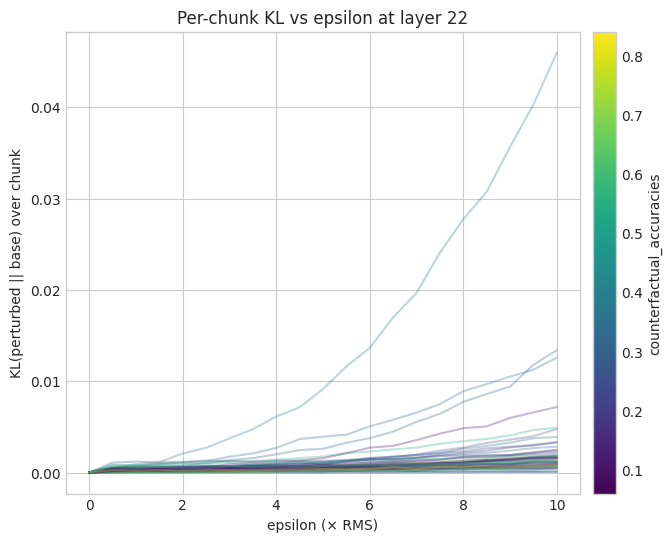

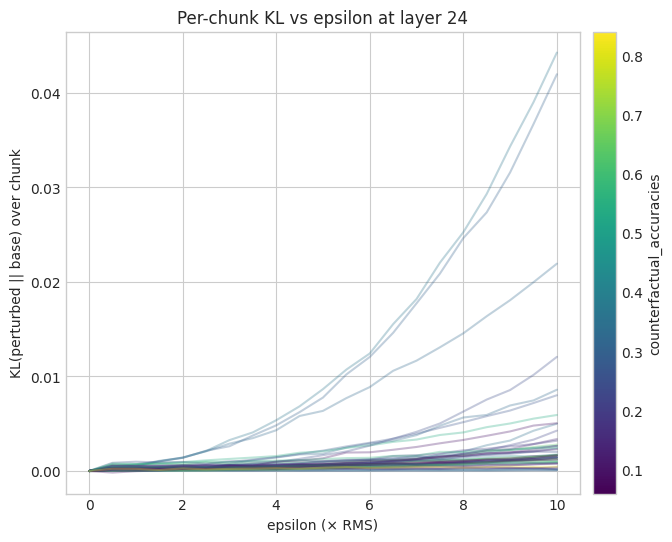

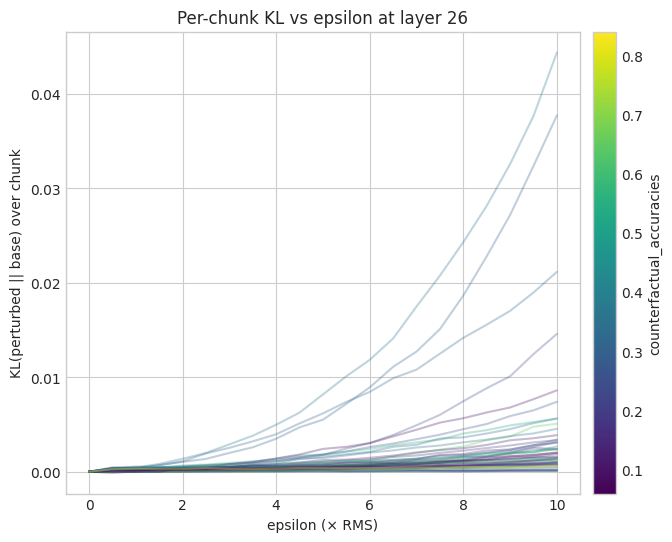

In [ ]:
# Plot per-chunk KL vs epsilon, color-coded by counterfactual_accuracies
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
plt.style.use('seaborn-v0_8-whitegrid')
for L in selected_layers:
    curves = chunk_curves.get(L, [])
    if not curves:
        continue
    imps = np.array([c['importance'] for c in curves], dtype=float)
    # Normalize importance to [0,1] for colormap
    imp_min, imp_max = float(np.nanmin(imps)), float(np.nanmax(imps) if np.any(np.isfinite(imps)) else 1.0)
    norm = Normalize(vmin=imp_min, vmax=imp_max if imp_max>imp_min else imp_min+1e-6)
    fig, ax = plt.subplots(figsize=(8,6))
    for entry in curves:
        color = viridis(norm(entry['importance']))
        ys = entry['ys']
        xs = [float(e) for e in epsilons]
        ax.plot(xs, ys, color=color, alpha=0.3, linewidth=1.5)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('counterfactual_accuracies')
    ax.set_xlabel('epsilon (× RMS)')
    ax.set_ylabel('KL(perturbed || base) over chunk')
    ax.set_title(f'Per-chunk KL vs epsilon at layer {L}')
    plt.show()

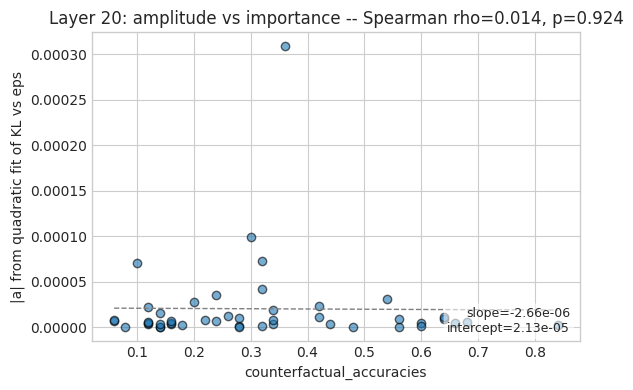

Layer 20: n_points=46, spearman_rho=0.014388057052617318, pval=0.9243912314427181, slope=-2.6622046653137783e-06, intercept=2.1319983688729814e-05


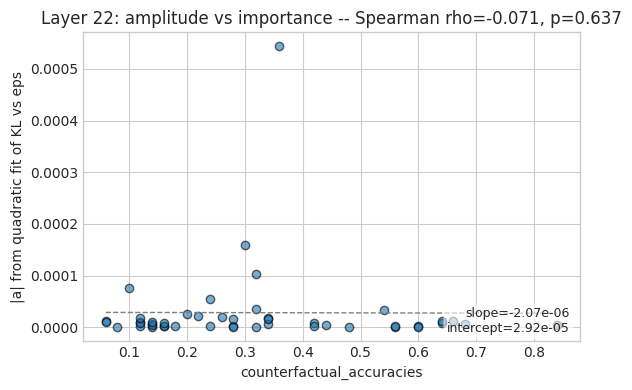

Layer 22: n_points=46, spearman_rho=-0.07144627472050745, pval=0.6370407876612982, slope=-2.074225383295892e-06, intercept=2.9167243264314238e-05


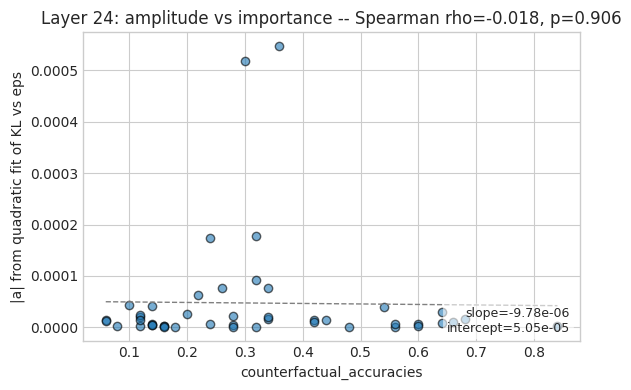

Layer 24: n_points=46, spearman_rho=-0.017907882168493656, pval=0.9059694199343218, slope=-9.78223131967435e-06, intercept=5.049084526379364e-05


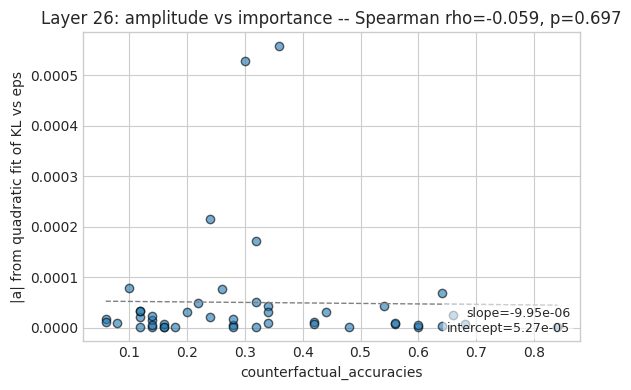

Layer 26: n_points=46, spearman_rho=-0.05891075720256189, pval=0.6973542947637741, slope=-9.950685440071399e-06, intercept=5.2695223946386184e-05


In [ ]:
# Fit each KL curve (y vs eps) to a quadratic and plot amplitude vs counterfactual_accuracies
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
# Use SciPy spearman if present; fallback to rank+pearson
try:
    from scipy.stats import spearmanr
    _have_scipy = True
except Exception:
    _have_scipy = False
# We'll treat amplitude as the absolute quadratic coefficient |a| from y(eps)=a*eps^2 + b*eps + c
eps_floats = np.array([float(e) for e in epsilons])
for L in selected_layers:
    curves = chunk_curves.get(L, [])
    if not curves:
        print(f'Layer {L}: no chunk curves found')
        continue
    amplitudes = []  # |a| values
    importances = []
    for c_ in curves:
        ys = np.array(c_.get('ys', []), dtype=float)
        # Align lengths (use min length)
        if ys.size == 0:
            continue
        n = min(len(eps_floats), len(ys))
        x = eps_floats[:n]
        y = ys[:n]
        # Require at least 3 points to fit a quadratic
        if len(x) < 3 or np.all(np.isnan(y)):
            continue
        # Robustly fit degree-2 polynomial
        try:
            coeffs = np.polyfit(x, y, 2)  # [a, b, c]
            a = float(coeffs[0])
            amp = float(np.abs(a))
        except Exception:
            amp = np.nan
        if not np.isnan(amp):
            amplitudes.append(amp)
            importances.append(float(c_.get('importance', 0.0)))
    if len(amplitudes) == 0:
        print(f'Layer {L}: no valid quadratic fits')
        continue
    x = np.array(importances)
    y = np.array(amplitudes)
    # Compute Spearman correlation between importance and amplitude
    if _have_scipy:
        try:
            rho, pval = spearmanr(x, y)
        except Exception:
            rho, pval = np.nan, np.nan
    else:
        # fallback: rank + Pearson on ranks
        def _ranks(arr):
            order = np.argsort(arr)
            ranks = np.empty_like(order, dtype=float)
            ranks[order] = np.arange(len(arr), dtype=float)
            return ranks
        rx = _ranks(x)
        ry = _ranks(y)
        if np.nanstd(rx) == 0 or np.nanstd(ry) == 0:
            rho, pval = np.nan, np.nan
        else:
            rho = float(np.corrcoef(rx, ry)[0,1])
            pval = np.nan
    # Plot amplitude vs importance (no colorbar)
    fig, ax = plt.subplots(figsize=(6,4))
    sc = ax.scatter(x, y, edgecolor='black', alpha=0.6)
    ax.set_xlabel('counterfactual_accuracies')
    ax.set_ylabel('|a| from quadratic fit of KL vs eps')
    title = f'Layer {L}: amplitude vs importance -- Spearman rho={np.nan if rho is None else float(rho):.3f}'
    if not np.isnan(pval):
        title += f', p={float(pval):.3g}'
    ax.set_title(title)
    # Optional linear guide for visualization + annotate slope/intercept
    try:
        slope, intercept = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        ax.plot(xs, slope*xs + intercept, color='gray', linestyle='--', linewidth=1)
        ax.text(0.98, 0.02, f'slope={slope:.3g}\nintercept={intercept:.3g}', transform=ax.transAxes, ha='right', va='bottom', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))
    except Exception:
        slope, intercept = np.nan, np.nan
    plt.tight_layout()
    plt.show()
    print(f'Layer {L}: n_points={len(x)}, spearman_rho={rho}, pval={pval}, slope={slope}, intercept={intercept}')


## Anisotropy of Random Perturbations

Beyond isotropic averaging across random directions, we quantify anisotropy by sampling multiple
random unit directions and measuring the spread of KL divergences at a fixed epsilon and layer.
We report metrics like max/min ratio and coefficient of variation across directions per chunk.


In [ ]:
# Configure anisotropy probe
anisotropy_eps = None
# Prefer an epsilon around 1.0 if present, else pick the median of existing epsilons
if 'epsilons' in globals() and isinstance(epsilons, (list, tuple)) and len(epsilons)>0:
    if any(abs(float(e)-1.0)<1e-6 for e in epsilons):
        anisotropy_eps = 1.0
    else:
        anisotropy_eps = float(epsilons[len(epsilons)//2])
else:
    anisotropy_eps = 1.0
n_dirs_aniso = 16

anisotropy_stats = {L: [] for L in selected_layers}

# Iterate examples and chunks (teacher-forced alignment as in prior sections)
for ex_idx, ex in enumerate(examples, start=1):
    question = ex.get('prompt','')
    cot_text = ex.get('cot') or ''
    try:
        from utils import split_solution_into_chunks
        chunks = split_solution_into_chunks(cot_text)
    except Exception:
        import re
        chunks = [p.strip() for p in re.split(r'(?<=[\.\!\?])\s+|\n\n+', cot_text) if p.strip()]
    if not chunks:
        continue

    for chunk_idx, chunk_text in enumerate(chunks):
        prefix_text = '\n'.join(chunks[:chunk_idx])
        chunk_ids = tokenizer(chunk_text, return_tensors='pt', add_special_tokens=False)['input_ids']
        n_steps = int(chunk_ids.shape[-1])
        prompt_prefix = (
            'Solve the following problem step by step. You MUST put your final answer in \boxed{}.\n\n'
            + f'Problem: {question}\n\n'
            + 'Solution:\n<think>\n'
            + prefix_text
        )
        enc_prefix = tokenizer(prompt_prefix, return_tensors='pt')
        ids_pref = enc_prefix['input_ids'].to(device)
        pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else (tokenizer.eos_token_id or 0)
        am_pref = (ids_pref != pad_id).long().to(device)
        enc_full = tokenizer(prompt_prefix + chunk_text, return_tensors='pt')
        ids_full = enc_full['input_ids'].to(device)
        am_full = (enc_full['input_ids'] != pad_id).long().to(device)
        full_ids = ids_full[0].tolist()
        chunk_seq = tokenizer(chunk_text, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
        s_idx = -1
        for pos in range(max(0, ids_pref.shape[-1]-4), len(full_ids)-len(chunk_seq)+1):
            if full_ids[pos:pos+len(chunk_seq)] == chunk_seq:
                s_idx = pos; break
        if s_idx == -1:
            s_idx = int(ids_pref.shape[-1])
        start = max(0, s_idx - 1)
        logits_full = _forward_with_logits(ids_full, am_full)
        seq_len = int(logits_full.shape[1])
        n_eff = max(0, min(n_steps, seq_len - start))
        if n_eff == 0:
            continue
        base_span = logits_full[:, start:start+n_eff, :]
        base_avg = base_span.mean(dim=1)

        for L in selected_layers:
            dir_kls = []
            for _ in range(n_dirs_aniso):
                d = unit_random_direction(hidden_size, device=device, dtype=torch.float32)
                steered_logits = logits_with_random_perturb_full(ids_full, am_full, float(anisotropy_eps), L, d, start)
                steered_span = steered_logits[:, start:start+n_eff, :]
                # Reuse kl_from_logits if defined; else fallback to kl_between_logits
                try:
                    kl_t = kl_from_logits(steered_span.reshape(-1, steered_span.shape[-1]), base_span.reshape(-1, base_span.shape[-1]))
                    dir_kls.append(float(kl_t.mean().item()))
                except Exception:
                    dir_kls.append(kl_between_logits(steered_span.reshape(-1, steered_span.shape[-1]), base_span.reshape(-1, base_span.shape[-1])))
            if dir_kls:
                arr = np.array(dir_kls, dtype=float)
                mean_kl = float(arr.mean()); std_kl = float(arr.std()); min_kl = float(arr.min()); max_kl = float(arr.max())
                ratio = float(max_kl / (min_kl + 1e-12)); cv = float(std_kl / (mean_kl + 1e-12))
                anisotropy_stats[L].append({
                    'example_index': ex_idx-1, 'chunk_index': chunk_idx,
                    'eps': float(anisotropy_eps), 'mean_kl': mean_kl, 'std_kl': std_kl,
                    'min_kl': min_kl, 'max_kl': max_kl, 'ratio_max_min': ratio, 'cv': cv,
                })

# Plot anisotropy histograms and scatter per layer
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
for L in selected_layers:
    stats = anisotropy_stats.get(L, [])
    if not stats:
        print(f'Layer {L}: no anisotropy data'); continue
    ratios = np.array([s['ratio_max_min'] for s in stats], dtype=float)
    means = np.array([s['mean_kl'] for s in stats], dtype=float)
    cvs = np.array([s['cv'] for s in stats], dtype=float)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].hist(ratios, bins=20, alpha=0.8, color='#5DA5DA')
    ax[0].set_title(f'Layer {L}: anisotropy ratio (max/min)')
    ax[0].set_xlabel('max KL / min KL'); ax[0].set_ylabel('count')
    sc = ax[1].scatter(means, ratios, c=cvs, cmap='viridis', alpha=0.7)
    ax[1].set_title(f'Layer {L}: mean KL vs anisotropy')
    ax[1].set_xlabel('mean KL across directions'); ax[1].set_ylabel('max/min KL')
    cb = plt.colorbar(sc, ax=ax[1]); cb.set_label('coefficient of variation (std/mean)')
    plt.tight_layout(); plt.show()

KeyboardInterrupt: 